In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generating the XOR Dataset
		according to the tensorflow playground website
	

In [3]:
def custom_xor(x,y):
    if x*y >= 0:
        return 1
    else:
        return -1
def pad_data(x):
    p = 0.3
    if x>0:
        return x+p
    else:
        return x-p
def rand_uniform(a,b):
    r = np.random.rand()
    r = r*(b-a)+a
    return r
def generate_xor_dataset(numsamples,noise=0):
    data = []
    padding = 0.3
    for i in range(numsamples):
        x = rand_uniform(-5,5)
        y = rand_uniform(-5,5)
        x = pad_data(x)
        y = pad_data(y)
        noiseX = rand_uniform(-5,5)*noise
        noiseY = rand_uniform(-5,5)*noise
        # x,y = x+noiseX,y+noiseY
        label = custom_xor(x+noiseX,y+noiseY)
        data.append([x,y,label])
    # data = np.array(data)
    return data
        

In [4]:
data_0 = generate_xor_dataset(400)

In [5]:
def plot_data(data):#Function to plot data with 2 features and 2 labels
	data = np.array(data)
	X = data[:,:2]
	y = data[:,2]
	colors = ['blue' if label == 1 else 'orange' for label in y]
	plt.scatter(X[:,0],X[:,1], c = colors,marker='.')
	plt.axhline(0, color='gray', linewidth=1, linestyle='-')  # X-axis line at y=0
	plt.axvline(0, color='gray', linewidth=1, linestyle='-')  # Y-axis line at x=0
	plt.show()

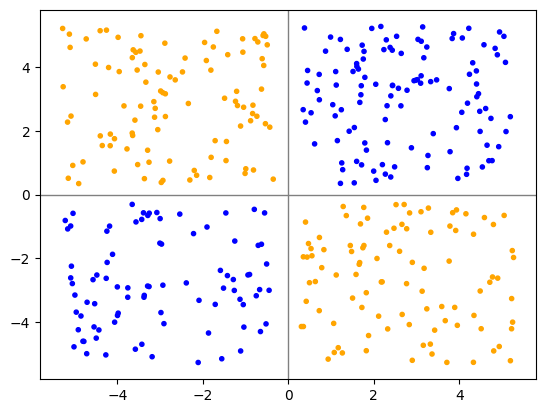

In [6]:
plot_data(data_0)

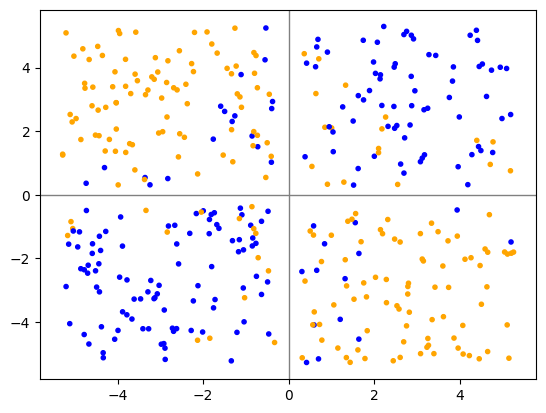

In [7]:
data_05 = generate_xor_dataset(400,0.5)
plot_data(data_05)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Epoch 0, Loss: 0.748828649520874, Val Loss: 0.7435969114303589
Epoch 10, Loss: 0.6130548715591431, Val Loss: 0.6004878282546997
Epoch 20, Loss: 0.4570003151893616, Val Loss: 0.4397575259208679
Epoch 30, Loss: 0.254006564617157, Val Loss: 0.24143894016742706
Epoch 40, Loss: 0.11520030349493027, Val Loss: 0.11624966561794281


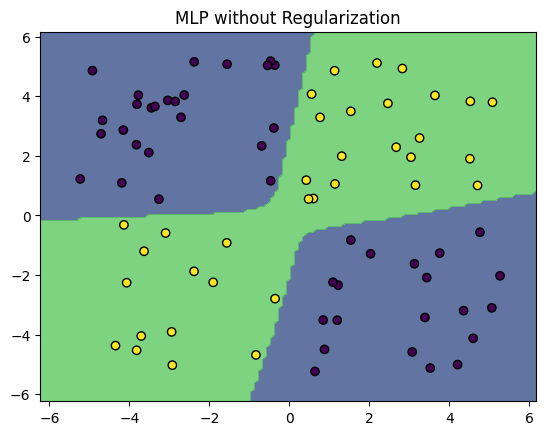

Epoch 0, Loss: 0.9319466352462769, Val Loss: 0.6926195025444031
Epoch 10, Loss: 0.7700207829475403, Val Loss: 0.5998446345329285
Epoch 20, Loss: 0.6409041285514832, Val Loss: 0.4901030957698822
Epoch 30, Loss: 0.5234774947166443, Val Loss: 0.3528966009616852
Epoch 40, Loss: 0.41638413071632385, Val Loss: 0.2145371437072754


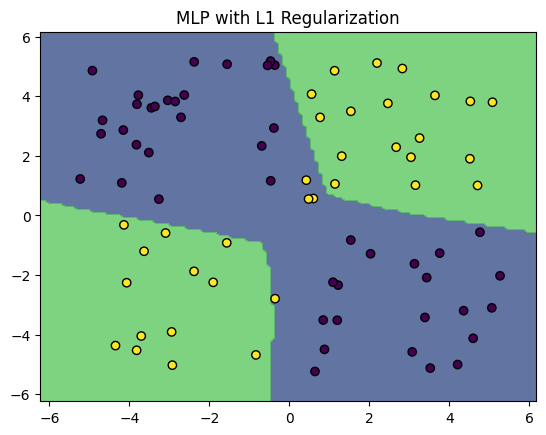

Epoch 0, Loss: 0.8230774402618408, Val Loss: 0.7271878123283386
Epoch 10, Loss: 0.6064819097518921, Val Loss: 0.5424425005912781
Epoch 20, Loss: 0.4374350905418396, Val Loss: 0.36286863684654236
Epoch 30, Loss: 0.30647507309913635, Val Loss: 0.24362340569496155
Epoch 40, Loss: 0.21780455112457275, Val Loss: 0.1384425163269043


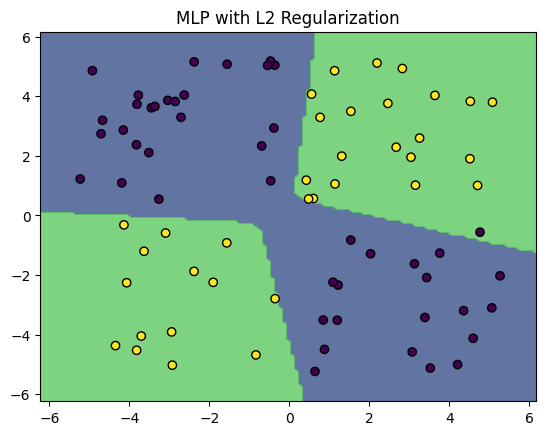

Epoch 0, Loss: 2.2462899684906006
Epoch 50, Loss: 0.15318194031715393
Epoch 100, Loss: 0.11202070116996765
Epoch 150, Loss: 0.09295572340488434


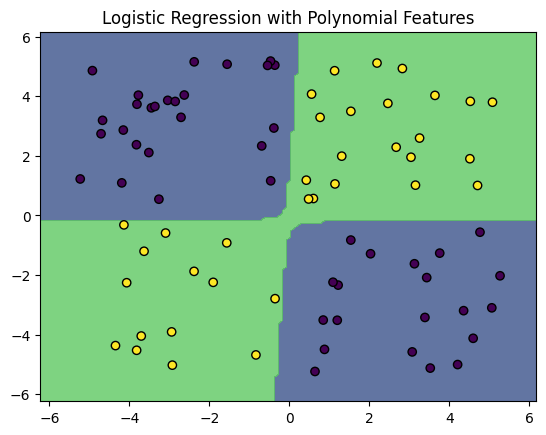

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Data Generation
data = generate_xor_dataset(400)  # 200 train + 200 test
data = np.array(data)
X, y = data[:, :2], data[:, 2]
y = (y > 0).astype(int)  # Convert labels to binary (1 for positive, 0 for negative)

# Split data into training, validation, and test sets manually
def split_data(X, y, train_size=0.6, val_size=0.2):
    total_samples = len(X)
    train_end = int(train_size * total_samples)
    val_end = int((train_size + val_size) * total_samples)

    X_train, y_train = torch.tensor(X[:train_end], dtype=torch.float32), torch.tensor(y[:train_end], dtype=torch.float32)
    X_val, y_val = torch.tensor(X[train_end:val_end], dtype=torch.float32), torch.tensor(y[train_end:val_end], dtype=torch.float32)
    X_test, y_test = torch.tensor(X[val_end:], dtype=torch.float32), torch.tensor(y[val_end:], dtype=torch.float32)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

# Function to plot decision boundaries
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = model(grid).detach().numpy().reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title(title)
    plt.show()

# Define MLP Model with optional L1 and L2 regularization
class MLP(nn.Module):
    def __init__(self, l1=0, l2=0):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
        self.l1 = l1
        self.l2 = l2

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

    def regularization_loss(self):
        l1_loss = self.l1 * (torch.norm(self.fc1.weight, 1) + torch.norm(self.fc2.weight, 1) + torch.norm(self.fc3.weight, 1))
        l2_loss = self.l2 * (torch.norm(self.fc1.weight, 2) + torch.norm(self.fc2.weight, 2) + torch.norm(self.fc3.weight, 2))
        return l1_loss + l2_loss

# Training function
def train_model(model, X_train, y_train, X_val, y_val, epochs=50):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train).squeeze()
        loss = criterion(output, y_train) + model.regularization_loss()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            model.eval()
            val_output = model(X_val).squeeze()
            val_loss = criterion(val_output, y_val)
            print(f'Epoch {epoch}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')

# MLP without Regularization
model_mlp = MLP()
train_model(model_mlp, X_train, y_train, X_val, y_val)
plot_decision_boundary(lambda x: model_mlp(x).squeeze() > 0.5, X_test, y_test, "MLP without Regularization")

# MLP with L1 Regularization
best_l1_penalty = 0.01  # Adjust based on experimentation
model_l1 = MLP(l1=best_l1_penalty)
train_model(model_l1, X_train, y_train, X_val, y_val)
plot_decision_boundary(lambda x: model_l1(x).squeeze() > 0.5, X_test, y_test, "MLP with L1 Regularization")

# MLP with L2 Regularization
best_l2_penalty = 0.01  # Adjust based on experimentation
model_l2 = MLP(l2=best_l2_penalty)
train_model(model_l2, X_train, y_train, X_val, y_val)
plot_decision_boundary(lambda x: model_l2(x).squeeze() > 0.5, X_test, y_test, "MLP with L2 Regularization")

# Logistic Regression with Polynomial Features (without sklearn)
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Manual polynomial feature expansion
def polynomial_features(X, degree=2):
    poly_features = [X]  # Start with original features

    for d in range(2, degree + 1):
        for i in range(d + 1):
            feature = (X[:, 0]**(d - i)) * (X[:, 1]**i)
            poly_features.append(feature.view(-1, 1))  # Reshape to [240, 1]

    return torch.cat(poly_features, dim=1)  # Concatenate along the second dimension

X_poly_train = polynomial_features(X_train, degree=2)
X_poly_test = polynomial_features(X_test, degree=2)

log_reg = LogisticRegressionModel(X_poly_train.shape[1])
optimizer = optim.SGD(log_reg.parameters(), lr=0.01)
criterion = nn.BCELoss()

# Training Logistic Regression
for epoch in range(200):
    log_reg.train()
    optimizer.zero_grad()
    output = log_reg(X_poly_train).squeeze()
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Plot decision boundary for Logistic Regression with polynomial features
plot_decision_boundary(lambda x: log_reg(polynomial_features(x)).squeeze() > 0.5, X_test, y_test, "Logistic Regression with Polynomial Features")
